# BPT Diagram for SBS 0335$-$052 W and Spectra Simulations for uncertainties
By María Chillarón Víctor. 

Master's Thesis: 'Introduction to bidimensional studies of low-mass galaxies with MEGARA/GTC'. Supervised by Jesús Gallego, Cristina Cabello and Nicolás Cardiel. Universidad Complutense de Madrid. June 2024.

In [1]:
from astropy.io import fits
from astropy.io import ascii
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy import units as u
from PIL import Image
from datetime import datetime

import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import teareduce as tea

This code consists of different sections:
 - Sections I and II focus on fitting the spectral lines with Gaussians. The code was taken from the Experimental Techniques in Astrophysics classes of the Master's in Astrophysics at UCM. Prof. Nicolás Cardiel and Jesús Gallego during 2023-2024 academic year.
 - Section III: Calculation of ratios
 - Section IV: Simulations for uncertainties
 - Section V: BPT Diagram
 - Section VI: Metallicities

# I. LR-R. Lines H$\alpha$ and [NII]

## Step 0. Visualization of the spectra to be fitted

Text(0, 0.5, 'Flux (arbitrary units)')

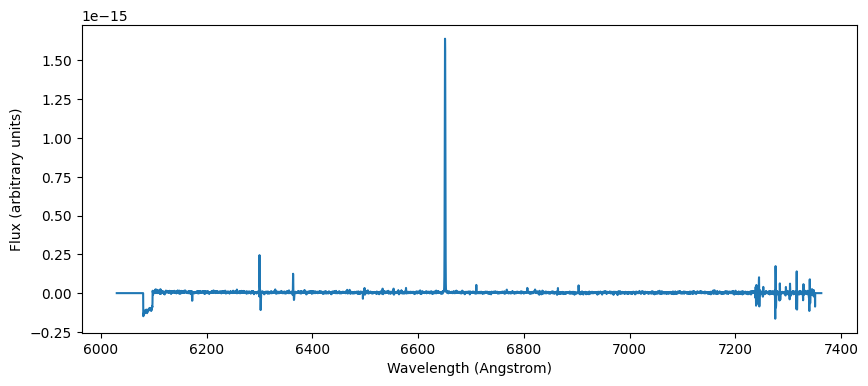

In [3]:
table = ascii.read('spectrum_SBSW_erg_node2.txt')

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(table['wavelength'], table['flux'])
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (arbitrary units)')

### Zoom of the lines

In [4]:
# central wavelengths of [NII] lines and Halpha
wave_N1 = 6548.05
wave_Ha = 6562.79
wave_N2 = 6583.45

In [5]:
# approximate redshift
z = 0.013379

In [18]:
def plot_spectrum(xmin, xmax):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(table['wavelength'], table['flux'], label='initial spectrum')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlim(xmin, xmax)

    ymin, ymax = ax.get_ylim()
    dy = ymax - ymin
    ymax += dy/4
    ax.set_ylim(ymin, ymax)


    for wave, label in zip([wave_N1, wave_Ha, wave_N2],
                           ['[NII]', r'${\rm H}\alpha$', '[NII]']):
        xp = (1 + z) * wave
        ax.plot([xp, xp], [ymax - dy/5, ymax-dy/10], color='C1')
        ax.text(xp, ymax - dy / 12, label, ha='center')
        
    return fig, ax

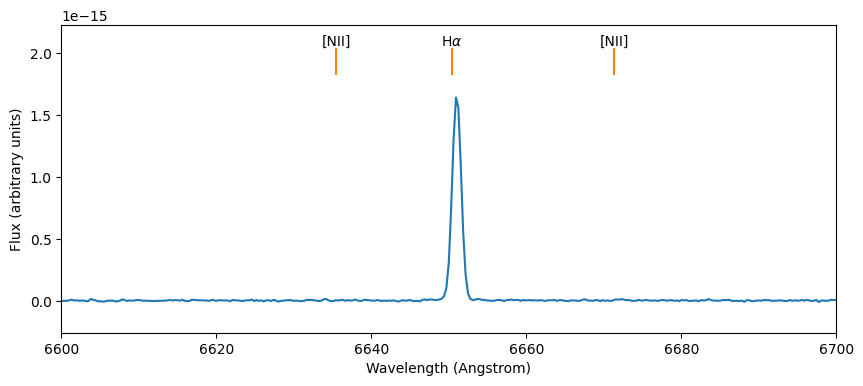

In [19]:
fig, ax = plot_spectrum(xmin=6600, xmax=6700)

## Step 1. Three lines with no constant continuum fitting.

In [8]:
model_continuum = models.Polynomial1D(degree=1, c0=10, c1=0)
model_n1 = models.Gaussian1D(amplitude= 0.0000000001, mean=wave_N1*(1+z), stddev=1)
model_ha = models.Gaussian1D(amplitude= 0.0000000001, mean=wave_Ha*(1+z), stddev=1)
model_n2 = models.Gaussian1D(amplitude= 0.0000000001, mean=wave_N2*(1+z), stddev=1)

model_spectrum = model_continuum + model_n1 + model_ha + model_n2
model_spectrum

# same stddev for the three lines
def tie_n1_stddev(model):
    return model.stddev_2
def tie_n2_stddev(model):
    return model.stddev_2
model_n1.stddev.tied = tie_n1_stddev
model_n2.stddev.tied = tie_n2_stddev

# amp([NII]6548) = amp([NII]6584) / 3
def tie_n1_amplitude(model):
    return model.amplitude_3 / 3
model_n1.amplitude.tied = tie_n1_amplitude

# the relative positions of the [NII] lines are tied to the position of Halpha
def tie_n1_mean(model):
    return model.mean_2 * (wave_N1/wave_Ha)
def tie_n2_mean(model):
    return model.mean_2 * (wave_N2/wave_Ha)
model_n1.mean.tied = tie_n1_mean
model_n2.mean.tied = tie_n2_mean

for item in model_spectrum.tied.items():
    print(item)

model_n1.stddev.tied = tie_n1_stddev
model_n2.stddev.tied = tie_n2_stddev
model_n1.amplitude.tied = tie_n1_amplitude
model_n1.mean.tied = tie_n1_mean
model_n2.mean.tied = tie_n2_mean

('c0_0', False)
('c1_0', False)
('amplitude_1', <function tie_n1_amplitude at 0x7f86b381e050>)
('mean_1', <function tie_n1_mean at 0x7f86b381e560>)
('stddev_1', <function tie_n1_stddev at 0x7f86b3bb5ab0>)
('amplitude_2', False)
('mean_2', False)
('stddev_2', False)
('amplitude_3', False)
('mean_3', <function tie_n2_mean at 0x7f86800b49d0>)
('stddev_3', <function tie_n2_stddev at 0x7f86b3bb5a20>)


In [11]:
iok = np.where((table['wavelength'] >= 6620) & (table['wavelength'] <= 6680))
xfit = table[iok]['wavelength']
yfit = table[iok]['flux']

#fig, ax = plot_spectrum(xmin=6600, xmax=6700)
#ax.plot(xfit, yfit, 'C2o', label='points to be fitted')
#ax.legend()

In [12]:
# Now we fit the lines:
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(model_spectrum, x=xfit, y=yfit)
fitted_model.n_submodels

# We draw the fit:
xpredict = np.linspace(xfit[0], xfit[-1], num=1000)
ypredict = fitted_model(xpredict)

#fig, ax = plot_spectrum(xmin=6600, xmax=6700)
#ax.plot(xfit, yfit, 'C2o', label='points to be fitted')
#ax.plot(xpredict, ypredict, 'C3', label='fit')
#ax.legend()

## Step 2. We calculate the flux of the line.
A gaussian expressed as $y(x)=a \,{\rm e}^{-\frac{(x-x_0)^2}{2\sigma^2}}$, has an area inside of $a\,\sigma\, \sqrt{2\pi}$.

In [13]:
area_NII_1 = fitted_model.amplitude_1 * fitted_model.stddev_1 * np.sqrt(2 * np.pi)
area_Halpha = fitted_model.amplitude_2 * fitted_model.stddev_2 * np.sqrt(2 * np.pi)
area_NII_2 = fitted_model.amplitude_3 * fitted_model.stddev_3 * np.sqrt(2 * np.pi)

print(area_NII_1)
print(area_Halpha)
print(area_NII_2)

3.736854736248463e-18
2.35228699561678e-15
1.1210564208745388e-17


# II. LR-B. Lines H$\beta$ and [OIII]5007

## Step 0. Visualization of the spectra to be fitted

Text(0, 0.5, 'Flux (erg s^-1 cm^-2 A^-1)')

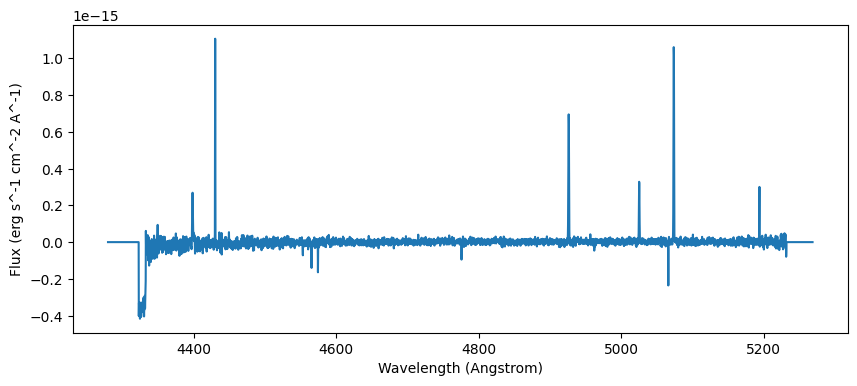

In [15]:
table2 = ascii.read('spectrum_SBSW_erg_LRB_node2.txt')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(table2['wavelength'], table2['flux'])
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (erg s^-1 cm^-2 A^-1)')

In [20]:
def plot_spectrum_LRB(xmin, xmax):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(table2['wavelength'], table2['flux'], label='initial spectrum')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlim(xmin, xmax)

    ymin, ymax = ax.get_ylim()
    dy = ymax - ymin
    ymax += dy/4
    ax.set_ylim(ymin, ymax)


    for wave, label in zip([wave_OIII, wave_Hb],
                           ['[OIII]', r'${\rm H}\beta$']):
        xp = (1 + z) * wave
        ax.plot([xp, xp], [ymax - dy/5, ymax-dy/10], color='C1')
        ax.text(xp, ymax - dy / 12, label, ha='center')
        
    return fig, ax

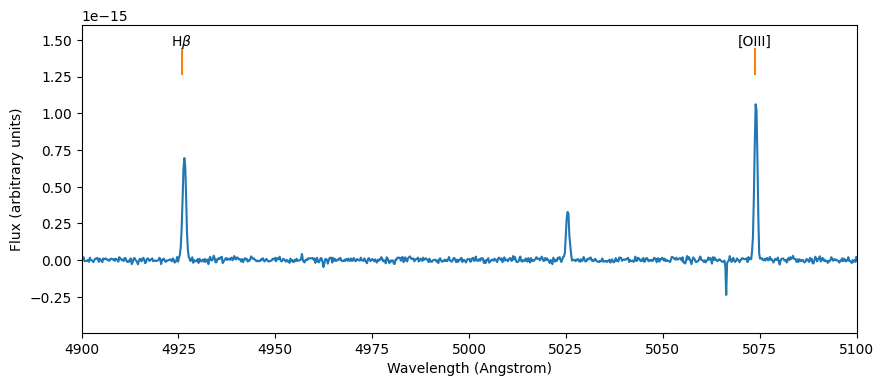

In [21]:
wave_OIII = 5007
wave_Hb = 4861
z = 0.01335
fig, ax = plot_spectrum_LRB(xmin=4900, xmax=5100)

## Step 1. Fitting one line.

### a) [OIII]5007

In [23]:
def ajuste_linea(wave_line, min_fit_line, max_fit_line):
    model_continuum = models.Const1D(amplitude=0.001)
    model_line = models.Gaussian1D(amplitude= 1, mean=wave_line*(1+z), stddev=1)
    model_spectrum = model_continuum + model_line

    # Selection of the data to be fitted:
    iok_line = np.where((table2['wavelength'] >= min_fit_line) & (table2['wavelength'] <= max_fit_line))
    xfit = table2[iok_line]['wavelength']
    yfit = table2[iok_line]['flux']
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(model_spectrum, x=xfit, y=yfit)

    #for i in range(fitted_model.n_submodels):
    #    print(f'\n* Model component #{i}')
    #    print(fitted_model[i])

    xpredict = np.linspace(xfit[0], xfit[-1], num=1000)
    ypredict = fitted_model(xpredict)
    
    fig, ax = plot_spectrum_LRB(xmin=4900, xmax=5100)
    ax.plot(xfit, yfit, 'C2o', label='points to be fitted')
    ax.plot(xpredict, ypredict, 'C3', label='fit')
    ax.legend()

    area = fitted_model.amplitude_1 * fitted_model.stddev_1 * np.sqrt(2 * np.pi)
    return area

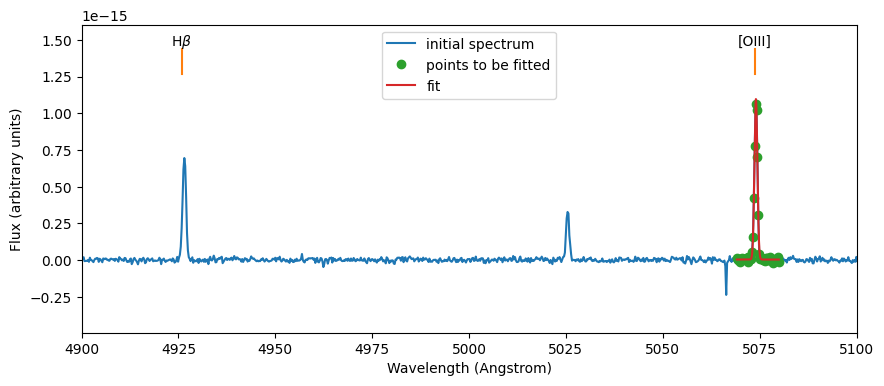

In [24]:
flux_original_OIII = ajuste_linea(wave_OIII, 5069, 5080)

### b) H$\beta$

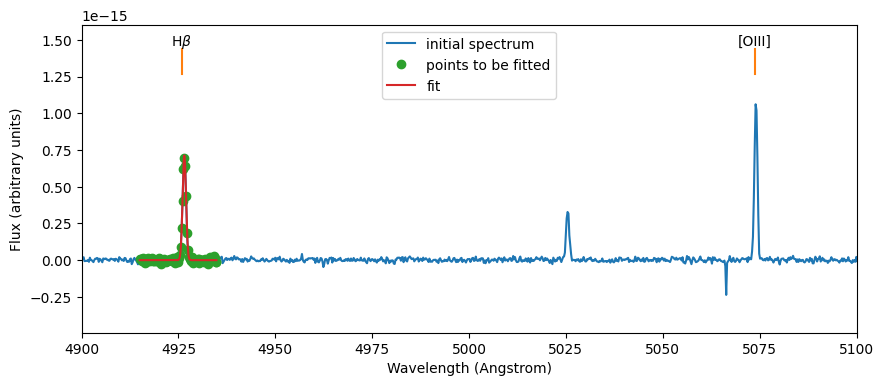

In [25]:
flux_original_Hbeta = ajuste_linea(wave_Hb, 4915, 4935)

## III. Line Ratios

In [40]:
# H alpha and NII
ratio_NII_Halpha = np.log10((area_NII_2)/area_Halpha) * u.erg * (u.s)**(-1) * (u.cm)**(-2) * (u.AA)**(-1)
print(ratio_NII_Halpha)

-2.321862837176841 erg / (Angstrom s cm2)


In [41]:
# [OIII] and Hbeta
ratio_OIII_Hbeta_original = np.log10(flux_original_OIII/flux_original_Hbeta) * u.erg * (u.s)**(-1) * (u.cm)**(-2) * (u.AA)**(-1)
print(ratio_OIII_Hbeta_original)

0.12202180445555814 erg / (Angstrom s cm2)


## IV. Simulations for Uncertainties

In [76]:
def histogram_drawing(datos, color, xlabel, name_save):
    plt.hist(datos, bins=50, color=color, alpha=0.5, edgecolor='black')

    # Calculation of the mean, median and percentiles
    media_x = np.mean(datos)
    mediana_x = np.median(datos)
    q_5_x, q_95_x = np.percentile(datos, [5, 95])
    q_16_x, q_84_x = np.percentile(datos, [16, 84])
    desviacion_estandar_x = np.std(datos)

    # We add them to the figure
    plt.axvline(media_x, color='black', linestyle='-', label='Mean')
    plt.axvline(mediana_x, color='red', linestyle='-', label='Median')
    plt.axvspan(q_5_x, q_95_x, color='hotpink', alpha=0.15, label='95%')
    plt.axvspan(q_16_x, q_84_x, color='gray', alpha=0.2, label='68%')
    plt.xlabel(f'{xlabel}')

    # Legend
    plt.legend()

    #Save the histogram
    plt.savefig(f'{name_save}', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return q_5_x, q_95_x,q_16_x, q_84_x


### a) 3 lines

In [43]:
min_lambda = 6620
max_lambda = 6680

# We calculate this with the original spectrum
iok = np.where((table['wavelength'] >= min_lambda) & (table['wavelength'] <= max_lambda))
xfit = table[iok]['wavelength']
yfit = table[iok]['flux']

In [44]:
# Calculation of rms
start_region = 6620  
end_region = 6630

iok2 = np.where((table['wavelength'] >= start_region) & (table['wavelength'] <= end_region))
flujo_rms = table[iok2]['flux']

rms = np.std(flujo_rms)

print("RMS:", rms)

RMS: 3.611957094348602e-18


In [45]:
def fitting_function(min_lambda, max_lambda, xfit, yfit, rms):
    # generates an array of random points following a normal (Gaussian) distribution.
    # loc: specifies the mean (μ) of the normal distribution. In this case, the mean is 0.0.
    # scale=rms. Specifies the standard deviation (σ) of the normal distribution.
    # size: Specifies the number of random points to generate.
    
    random_points = np.random.normal(loc=0.0, scale=rms, size=len(xfit))
    new_random_flux = yfit + random_points
    
    # Fit:
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(model_spectrum, x=xfit, y=new_random_flux)

    area_NII_1 = fitted_model.amplitude_1 * fitted_model.stddev_1 * np.sqrt(2 * np.pi)
    area_Halpha = fitted_model.amplitude_2 * fitted_model.stddev_2 * np.sqrt(2 * np.pi)
    area_NII_2 = fitted_model.amplitude_3 * fitted_model.stddev_3 * np.sqrt(2 * np.pi)

    ratio_NII_Halpha = np.log10((area_NII_2)/area_Halpha)

    return [area_NII_1, area_Halpha, area_NII_2, ratio_NII_Halpha]



In [46]:
# Simulation
NII_1_flux = []
Halpha_flux = []
NII_2_flux = []
log10_line_ratio_Halpha_NII = []
num_simul = 1000

for i in range(1, num_simul):
    results_fit = fitting_function(min_lambda, max_lambda, xfit, yfit, rms)
    #print(results_fit)

    NII_1_flux.append(results_fit[0])
    Halpha_flux.append(results_fit[1])
    NII_2_flux.append(results_fit[2])
    log10_line_ratio_Halpha_NII.append(results_fit[3])
    

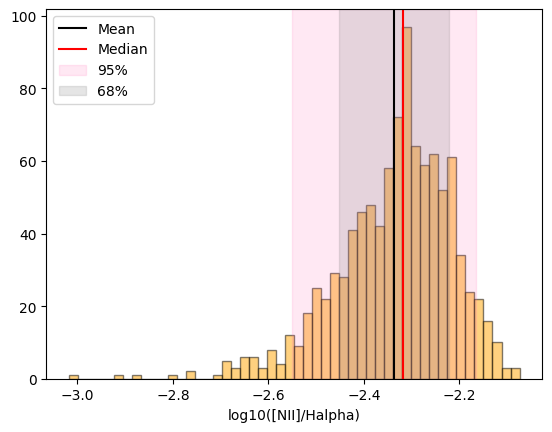

In [80]:
datos = log10_line_ratio_Halpha_NII
color = 'orange'
xlabel = 'log10([NII]/Halpha)'
name_save = 'BPT_Histogram_NHalpha.pdf'


percentiles_Halfa_NII = histogram_drawing(datos, color, xlabel, name_save)

In [81]:
# 1 sigma
incert_x_inf_68 = np.abs(percentiles_Halfa_NII[2]-ratio_NII_Halpha.value)
incert_x_sup_68 = np.abs(ratio_NII_Halpha.value - percentiles_Halfa_NII[3])
print(incert_x_inf_68)
print(incert_x_sup_68)

0.12931414958177756
0.10071929367952581


In [82]:
# 2 sigma
incert_x_inf_95 = np.abs(percentiles_Halfa_NII[0]-ratio_NII_Halpha.value)
incert_x_sup_95 = np.abs(ratio_NII_Halpha.value - percentiles_Halfa_NII[1])
print(incert_x_inf_95)
print(incert_x_sup_95)

0.22945900039258138
0.15609756941927566


### b) 1 line

In [50]:
def fitting_function_1line(xfit, yfit, wave_line, rms):
    
    random_points = np.random.normal(loc=0.0, scale=rms, size=len(xfit))
    new_random_flux = yfit + random_points

    model_continuum = models.Const1D(amplitude=0.0001)
    model_line = models.Gaussian1D(amplitude= 1, mean=wave_line*(1+z), stddev=1)
    model_spectrum = model_continuum + model_line

    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(model_spectrum, x=xfit, y=new_random_flux)

    xpredict = np.linspace(xfit[0], xfit[-1], num=1000)
    ypredict = fitted_model(xpredict)
    
    area = fitted_model.amplitude_1 * fitted_model.stddev_1 * np.sqrt(2 * np.pi)

    return area

In [51]:
# Calculation of rms
start_region = 5030 
end_region = 5060

iok_line2 = np.where((table2['wavelength'] >= start_region) & (table2['wavelength'] <= end_region))
flujo_rms = table2[iok_line2]['flux']

rms = np.std(flujo_rms)
print("RMS:", rms)

RMS: 1.0975801348454128e-17


In [52]:
min_lambda_OIII = 5069
max_lambda_OIII = 5080
 
# We calculate this with the original spectrum
iok = np.where((table2['wavelength'] >= min_lambda_OIII) & (table2['wavelength'] <= max_lambda_OIII))
xfit = table2[iok]['wavelength']
yfit = table2[iok]['flux']

OIII_flux = []
num_simul = 1000

for i in range(1, num_simul):
    results_fit = fitting_function_1line(xfit, yfit, wave_OIII, rms)
    
    OIII_flux.append(results_fit)

In [54]:
min_lambda_Hb= 4915
max_lambda_Hb = 4935
 
# We calculate this with the original spectrum
iok = np.where((table2['wavelength'] >= min_lambda_Hb) & (table2['wavelength'] <= max_lambda_Hb))
xfit = table2[iok]['wavelength']
yfit = table2[iok]['flux']

Hb_flux = []
num_simul = 1000

for i in range(1, num_simul):
    results_fit = fitting_function_1line(xfit, yfit, wave_Hb, rms)
    
    Hb_flux.append(results_fit)

In [61]:
# 1000 simulated line ratios
ratio_OIII_Hbeta = np.log10(np.array(OIII_flux)/np.array(Hb_flux))

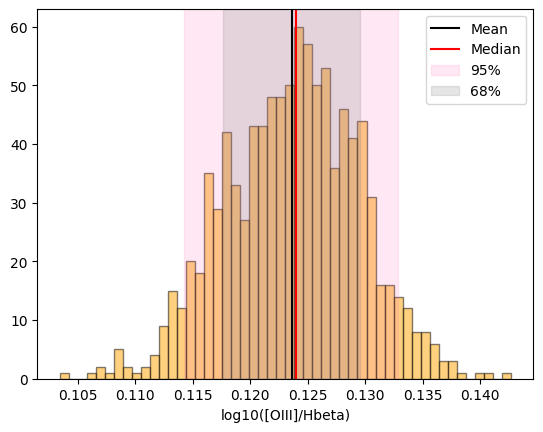

In [77]:
datos = ratio_OIII_Hbeta
color = 'orange'
xlabel = 'log10([OIII]/Hbeta)'
name_save = 'BPT_Histogram_OIIIHbeta.pdf'

percentiles_OIII_Hbeta = histogram_drawing(datos, color, xlabel, name_save)

In [78]:
# 1 sigma
incert_y_inf_68 = np.abs(percentiles_OIII_Hbeta[2]-ratio_OIII_Hbeta_original.value)
incert_y_sup_68 = np.abs(ratio_OIII_Hbeta_original.value - percentiles_OIII_Hbeta[3])
print(incert_y_inf_68)
print(incert_y_sup_68)

0.004411714793530017
0.007515239643659924


In [79]:
# 2 sigma
incert_y_inf_95 = np.abs(percentiles_OIII_Hbeta[0]-ratio_OIII_Hbeta_original.value)
incert_y_sup_95 = np.abs(ratio_OIII_Hbeta_original.value - percentiles_OIII_Hbeta[1])
print(incert_y_inf_95)
print(incert_y_sup_95)

0.007826315045144375
0.010841187244731224


## BPT Diagram

In [83]:
# Región 1
x_punto_reg1 = -2.181113284500972
y_punto_reg1 = 0.12230607537943818
incert_x_inf_reg1 = 0.058230681743941304
incert_x_sup_reg1 = 0.048492608530895875
incert_y_inf_reg1 = 0.0031910393433765977
incert_y_sup_reg1 = 0.004167437271909338

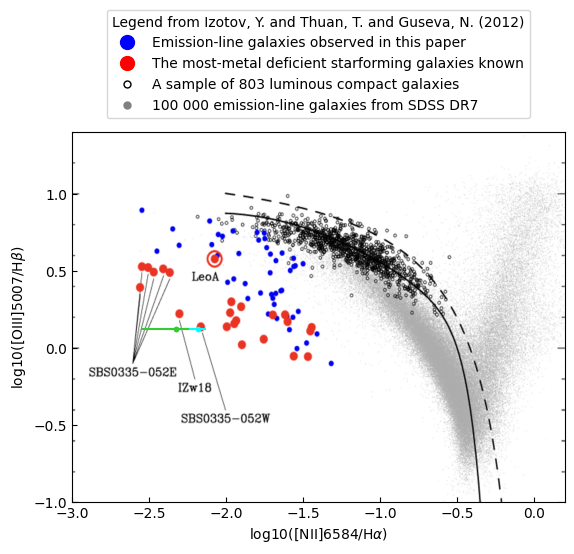

In [85]:
imagen = mpimg.imread('fig_BPT_SBSW_new.png')

fig, ax = plt.subplots()
ax.imshow(imagen, extent=[-3, 0.2, -1, 1.4])

# Limits and ticks of axis
ax.set_xlim(-3, 0.2)
ax.set_ylim(-1, 1.4)
#ax.set_xticks([-3, -2.8, -2.6, -2.4, -2.2, -2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2])
#ax.set_yticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])

ax.tick_params(axis='both', direction='in')

# I add the new point and its error bars
x_punto =  ratio_NII_Halpha.value
y_punto = ratio_OIII_Hbeta_original.value
ax.plot(x_punto, y_punto, marker='o', color='limegreen', markersize=3)  # 'ro' especifica que se dibuje un punto rojo
ax.errorbar(x_punto, y_punto, xerr=[[incert_x_inf_95], [incert_x_sup_95]], yerr=[[incert_y_inf_95], [incert_y_sup_95]], fmt='o', color='limegreen', markersize=3, label='Region 2')  
ax.errorbar(x_punto_reg1, y_punto_reg1, xerr=[[incert_x_inf_reg1], [incert_x_sup_reg1]], yerr=[[incert_y_inf_reg1], [incert_y_sup_reg1]], fmt='o', color='cyan', markersize=3, label='Region 1')  
#ax.errorbar(x_punto_spaxel, y_punto_spaxel, xerr=[[incert_x_inf_spaxel], [incert_x_sup_spaxel]], yerr=[[incert_y_inf_spaxel], [incert_y_sup_spaxel]], fmt='o', color='magenta', markersize=3, label='Brightest spaxel')  

ax.set_xlabel(r'log10([NII]6584/H$\alpha$)')
ax.set_ylabel(r'log10([OIII]5007/H$\beta$)')
#ax.set_title('BPT Diagram')

plt.legend(loc='upper left')

legend_elements = [
    Line2D([0], [0], marker='o', color='b', label='Emission-line galaxies observed in this paper', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='r', label='The most-metal deficient starforming galaxies known', markerfacecolor='red', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='.', color='k', label='A sample of 803 luminous compact galaxies', markerfacecolor='none', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='.', color='gray', label='100 000 emission-line galaxies from SDSS DR7', markersize=10, linestyle='None')
]

# Segunda leyenda fuera del gráfico
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.35), title='Legend from Izotov, Y. and Thuan, T. and Guseva, N. (2012)')

# Ajustar el diseño para que todo se vea bien
plt.savefig('DiagramaBPT_FINAL.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## VI. Metallicity

In [93]:
# PP04 Eq. 2
def OH_N2(N2):
    OH_N2 =  9.37 + 2.03 * N2 + 1.26 * N2**2 + 0.32*N2**3
    return OH_N2

In [91]:
# PP04 Eq. 3
def OH_O3N2(O3N2):
    OH_O3N2 =  8.73 - 0.32*O3N2
    return OH_O3N2

In [92]:
# Eq. 2 from Marino et al. 2013
def OH_O3N2_II(O3N2):
    OH_O3N2_II =  8.533 - 0.214 * O3N2
    return OH_O3N2_II

### a) N2 Index

In [94]:
N2 = ratio_NII_Halpha.value
OH_N2_reg2 = OH_N2(N2)
print(OH_N2_reg2)

7.443810739964278


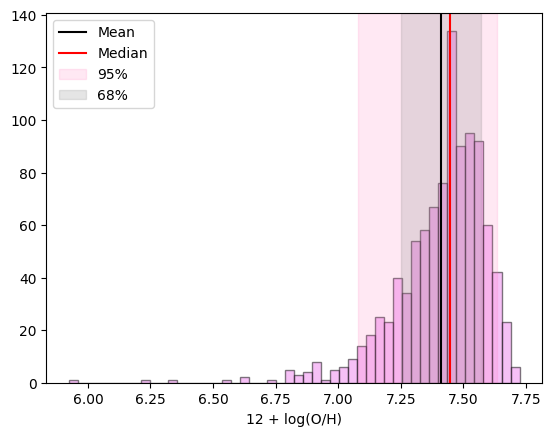

In [98]:
# Uncertainties
OH_N2_reg2_incert = OH_N2(np.array(log10_line_ratio_Halpha_NII))

datos = OH_N2_reg2_incert
color = 'violet'
xlabel = '12 + log(O/H)'
name_save = 'Histogram_OHN2_Reg1_test.pdf'
percentiles_OH_N2_reg2 = histogram_drawing(datos, color, xlabel, name_save)

In [99]:
# 1 sigma
incert_x_inf_OH_N2_reg2_68 = np.abs(percentiles_OH_N2_reg2[2] - OH_N2_reg2)
incert_x_sup_OH_N2_reg2_68 = np.abs(OH_N2_reg2 - percentiles_OH_N2_reg2[3])
print(incert_x_inf_OH_N2_reg2_68)
print(incert_x_sup_OH_N2_reg2_68)

0.19202708860155315
0.12690239969155392


In [100]:
# 2 sigma
incert_x_inf_OH_N2_reg2_95 = np.abs(percentiles_OH_N2_reg2[0]-OH_N2_reg2)
incert_x_sup_OH_N2_reg2_95 = np.abs(OH_N2_reg2 - percentiles_OH_N2_reg2[1])
print(incert_x_inf_OH_N2_reg2_95)
print(incert_x_sup_OH_N2_reg2_95)

0.36564345741105697
0.1890108209799637


### b) O3N2 Index

In [104]:
# Eq. PP04
O3N2 = np.log10( (10**(ratio_OIII_Hbeta_original.value))/(10**(ratio_NII_Halpha.value)) )
OH_O3N2_reg2 = OH_O3N2(O3N2)
print(OH_O3N2_reg2)

7.947956914677633


In [105]:
# Eq. de Marino et al 2013
OH_O3N2_reg2_II = OH_O3N2_II(O3N2)
print(OH_O3N2_reg2_II)

8.010008686690666


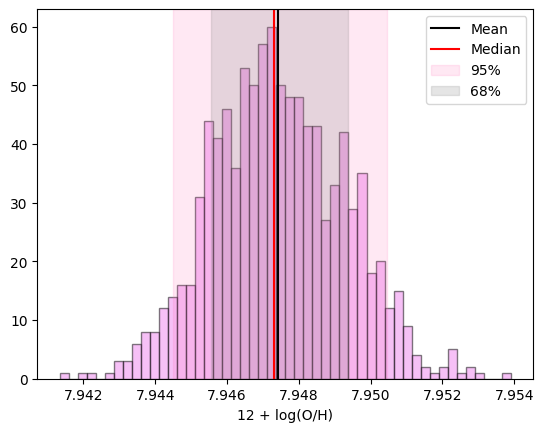

In [108]:
# Uncertainties
OH_O3N2_reg2_incert = OH_O3N2(np.array( np.log10( (10**(ratio_OIII_Hbeta))/(10**(ratio_NII_Halpha.value)) ) ))

datos = OH_O3N2_reg2_incert
color = 'violet'
xlabel = '12 + log(O/H)'
name_save = 'Histogram_O3N2_Reg2_test.pdf'
percentiles_OH_O3N2_reg2 = histogram_drawing(datos, color, xlabel, name_save)

In [109]:
# 1 sigma
incert_x_inf_OH_O3N2_reg2_68 = np.abs(percentiles_OH_O3N2_reg2[2] - OH_O3N2_reg2)
incert_x_sup_OH_O3N2_reg2_68 = np.abs(OH_O3N2_reg2 - percentiles_OH_O3N2_reg2[3])

print(incert_x_inf_OH_O3N2_reg2_68)
print(incert_x_sup_OH_O3N2_reg2_68)

0.0024048766859712245
0.0014117487339291301


In [110]:
# 2 sigma
incert_x_inf_OH_O3N2_reg2_95 = np.abs(percentiles_OH_O3N2_reg2[0] -OH_O3N2_reg2)
incert_x_sup_OH_O3N2_reg2_95 = np.abs(OH_O3N2_reg2 - percentiles_OH_O3N2_reg2[1])

print(incert_x_inf_OH_O3N2_reg2_95)
print(incert_x_sup_OH_O3N2_reg2_95)

0.0034691799183148575
0.0025044208144455737
